<a href="https://colab.research.google.com/github/maossand/balance_intelligente/blob/main/20250225_multi_input_multi_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split



import os #for creating directories
import shutil #for copying images to new folders
from multiprocessing import Pool
from tqdm import tqdm  # Progress bar for visibility


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import DF

In [3]:
#Import DF
os.chdir('/content/drive/MyDrive/packed_fruits/fruit_packed_data/')
df_varieties = pd.read_csv('df_cnn.csv')


#Selected fruits

batch_1 = ['apple_golden', 'apple_granny', 'apple_spartan', 'tomato_cherry_red',
           'tomato_cherry_yellow', 'tangerine_tangerine', 'lemon_yellow',
           'banana_yellow', 'apple_fuji', 'pepper_sweet_red', 'pepper_sweet_green'
           'tomato_bull_heart', 'orange_orange']

#Filter df

df_varieties = df_varieties[df_varieties['variety'].isin(batch_1)].copy()

#Create label for fruits

labels = df_varieties['variety'].unique()
labels_to_int = {label: idx for idx, label in enumerate(labels)}
df_varieties['label'] = df_varieties['variety'].map(labels_to_int)

#Fix the image path

df_varieties['image_path'] = df_varieties['subset'] + '_' + df_varieties['variety'] + '/' + df_varieties['file_name']

# 2. Test Train Validation Split


In [4]:
#Split the training set
from sklearn.model_selection import train_test_split

df_varieties_train = df_varieties[df_varieties['subset'] == 'train']
df_varieties_test = df_varieties[df_varieties['subset'] == 'test']

#Fix the image path

df_varieties['image_path'] = df_varieties['subset'] + '_' + df_varieties['variety'] + '/' + df_varieties['file_name']

#Split the DF

df_varieties_train = df_varieties[df_varieties['subset'] == 'train']
df_varieties_test = df_varieties[df_varieties['subset'] == 'test']

# Ensure df_train and df_test are full copies (not views)
df_train = df_varieties_train[['image_path', 'layout_id', 'label', 'packed','crowd', 'amount']].copy() #We use layout_id to create validation set
df_test = df_varieties_test[['image_path', 'layout_id', 'label', 'packed','crowd', 'amount']].copy()

# Define dataset paths
filtered_train_folder = "/content/resized_dataset/train/train_batch_1_resized/"
filtered_test_folder = "/content/resized_dataset/test/test_batch_1_resized/"

# Correctly update file paths
df_train["file_path"] = df_train["image_path"].apply(lambda x: os.path.join(filtered_train_folder, x))
df_test["file_path"] = df_test["image_path"].apply(lambda x: os.path.join(filtered_test_folder, x))


# Get unique layout IDs and associated labels
layout_df = df_train.groupby("layout_id")["label"].first().reset_index()

# Stratified split based on label distribution
train_layouts, val_layouts = train_test_split(
    layout_df["layout_id"], test_size=0.2, stratify=layout_df["label"], random_state=42
)


num_classes = len(df_train["label"].unique())
print(f"✅ Number of classes: {num_classes}")


# Extract train and validation data based on layout_id
df_val = df_train[df_train["layout_id"].isin(val_layouts)].copy()
df_train = df_train[df_train["layout_id"].isin(train_layouts)].copy()

print(f"✅ Train Layouts: {len(train_layouts)}, Validation Layouts: {len(val_layouts)}")
print(f"✅ Training samples: {len(df_train)}, Validation samples: {len(df_val)}")

✅ Number of classes: 10
✅ Train Layouts: 2398, Validation Layouts: 600
✅ Training samples: 9592, Validation samples: 2400


# Extract Images Dataset

In [5]:
#Extract train_dataset

import os
import zipfile

# Define train ZIP path in Google Drive
drive_train_zip = "/content/drive/MyDrive/packed_fruits/fruit_packed_data/resized_images/train_batch_1_resized/train_batch_1_resized.zip"

# Define local extraction folder
local_train_folder = "/content/resized_dataset/train/"

# Create folder if it doesn’t exist
os.makedirs(local_train_folder, exist_ok=True)

# Extract ZIP file
with zipfile.ZipFile(drive_train_zip, 'r') as zip_ref:
    zip_ref.extractall(local_train_folder)

print(f"✅ Train dataset extracted to {local_train_folder}")

✅ Train dataset extracted to /content/resized_dataset/train/


In [6]:
# Define test ZIP path in Google Drive
drive_test_zip = "/content/drive/MyDrive/packed_fruits/fruit_packed_data/resized_images/test_batch_1_resized/test_batch_1_resized.zip"

# Define local extraction folder
local_test_folder = "/content/resized_dataset/test/"

# Create folder if it doesn’t exist
os.makedirs(local_test_folder, exist_ok=True)

# Extract ZIP file
with zipfile.ZipFile(drive_test_zip, 'r') as zip_ref:
    zip_ref.extractall(local_test_folder)

print(f"✅ Test dataset extracted to {local_test_folder}")


✅ Test dataset extracted to /content/resized_dataset/test/


# Load and Preprocess the Images to Tensorflow



In [7]:
import tensorflow as tf

# Fixed Image Preprocessing Function
def load_and_preprocess_image(file_path, packed_label, fruit_label, crowd, amount):
    # Load raw image file (string format)
    image_raw = tf.io.read_file(file_path)

    # Extract shape before decoding (avoids unnecessary processing)
    image_shape = tf.image.extract_jpeg_shape(image_raw)  # Returns (height, width, channels)

    # Decode image only once (for both cases)
    image = tf.image.decode_jpeg(image_raw, channels=3)

    # Resize only if the image is NOT already 224x224
    image = tf.cond(
        tf.reduce_all(tf.equal(image_shape[:2], (224, 224))),  # Check if size is already 224x224
        lambda: tf.image.convert_image_dtype(image, tf.float32),  # Just normalize if correct size
        lambda: tf.image.resize(image, (224, 224)) / 255.0  # Resize + Normalize
    )

    # Convert labels
    packed_label = tf.cast(packed_label, tf.int32)  # Binary (Bag/No Bag)
    amount = tf.cast(amount, tf.float32)  # Regression (Fruit Count)
    crowd = tf.cast(crowd, tf.int32)  # Binary (Crowd)


    return image, (packed_label, fruit_label, crowd, amount)

    # Function to create TensorFlow dataset
def create_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((
        tf.constant(df["file_path"].values, dtype=tf.string),  # Ensure paths are tf.string
        tf.constant(df["packed"].values, dtype=tf.int32),  # Ensure labels are int32
        tf.constant(df["label"].values, dtype=tf.int32),  # Ensure labels are int32
        tf.constant(df["crowd"].values, dtype=tf.int32),  # Ensure crowd are int32
        tf.constant(df["amount"].values, dtype=tf.float32)  # Ensure amounts are float32
    ))

    # Apply preprocessing function
    dataset = dataset.map(lambda f, p, l, c, a: load_and_preprocess_image(f, p, l, c, a),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # format the dataset
    def format_inputs(image, labels):
        packed_label, fruit_label, crowd, amount = labels

        # Format the input to match the model input requirements
        return (
                {"image_input": image,
                 "num_fruits_input": tf.reshape(amount, (1,)),
                 "packed_input": tf.reshape(packed_label, (1,)),
                 "crowd_input": tf.reshape(crowd, (1,))},
                {"variety": tf.reshape(fruit_label, (1,)),
                 "count": tf.reshape(amount, (1,))})

    dataset = dataset.map(format_inputs)
    # Shuffle, batch, and prefetch for efficiency
    dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset
# %% [markdown]
#
# %%
# Re-create train and test datasets

train_dataset = create_dataset(df_train)
val_dataset = create_dataset(df_val)
test_dataset = create_dataset(df_test)

print("✅ Train and Test Datasets Successfully Created!")
# %%
# Save datasets
train_path = "/content/drive/MyDrive/packed_fruits/train_dataset.tfrecord"
val_path = "/content/drive/MyDrive/packed_fruits/val_dataset.tfrecord"
test_path = "/content/drive/MyDrive/packed_fruits/test_dataset.tfrecord"

# Save datasets
tf.data.experimental.save(train_dataset, train_path)
tf.data.experimental.save(val_dataset, val_path)
tf.data.experimental.save(test_dataset, test_path)

print("✅ Datasets saved as TFRecord files!")

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


✅ Train and Test Datasets Successfully Created!
✅ Datasets saved as TFRecord files!


Labels keys: dict_keys(['variety', 'count'])


<ipython-input-8-a768cc3f4470>:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  title += f"Fruit: {int(fruit_labels[idx])}\n"


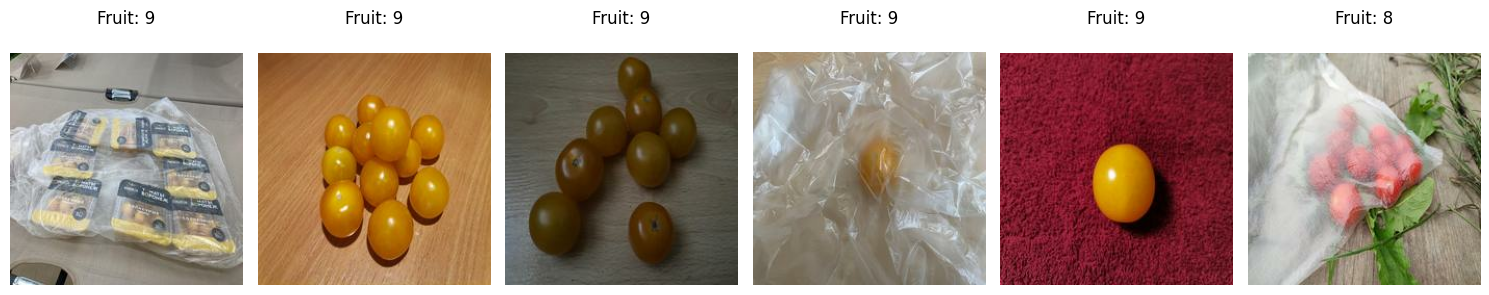

In [8]:
# Function to display a batch of random images with labels
def show_random_sample_images(dataset, num_images=6):
    # Take a random batch
    for batch in dataset.shuffle(1000).take(1):  # Shuffle dataset and take one batch
        images, labels_dict = batch  # Unpack the batch into images and labels

        # Print the keys of the labels dictionary to check what labels exist
        print("Labels keys:", labels_dict.keys())

        # Access labels from the dictionary (adjust based on available keys)
        packed_labels = labels_dict.get("packed_input", None)  # Safely get the packed_input
        fruit_labels = labels_dict.get("variety", None)  # Fruit variety label
        crowd_labels = labels_dict.get("crowd_input", None)  # Crowd status label
        amount_labels = labels_dict.get("num_fruits_input", None)  # Number of fruits label

        # If labels do not exist, print an appropriate message
        if packed_labels is not None:
            packed_labels = packed_labels.numpy()
        if fruit_labels is not None:
            fruit_labels = fruit_labels.numpy()
        if crowd_labels is not None:
            crowd_labels = crowd_labels.numpy()
        if amount_labels is not None:
            amount_labels = amount_labels.numpy()

        # Convert images tensor to numpy array
        images = images["image_input"].numpy()

        # Choose random indices for selecting images
        random_indices = np.random.choice(len(images), num_images, replace=False)

        # Create a figure to plot
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i, idx in enumerate(random_indices):
            axes[i].imshow(images[idx])  # Convert tensor to numpy array for visualization
            axes[i].axis("off")  # Remove axis ticks
            title = ""
            if packed_labels is not None:
                title += f"Packed: {int(packed_labels[idx])}\n"
            if fruit_labels is not None:
                title += f"Fruit: {int(fruit_labels[idx])}\n"
            if crowd_labels is not None:
                title += f"Crowd: {int(crowd_labels[idx])}\n"
            if amount_labels is not None:
                title += f"Amount: {int(amount_labels[idx])}"
            axes[i].set_title(title)
        plt.tight_layout()  # Adjust layout so titles and images fit well
        plt.show()
        break  # Stop after one batch

# Show random sample images from train dataset
show_random_sample_images(train_dataset)


<ipython-input-9-d91139bd2478>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[i].set_title(f"Fruit: {int(fruit_labels[idx])}\n"
<ipython-input-9-d91139bd2478>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"Count: {int(count_labels[idx])}")  # Display labels


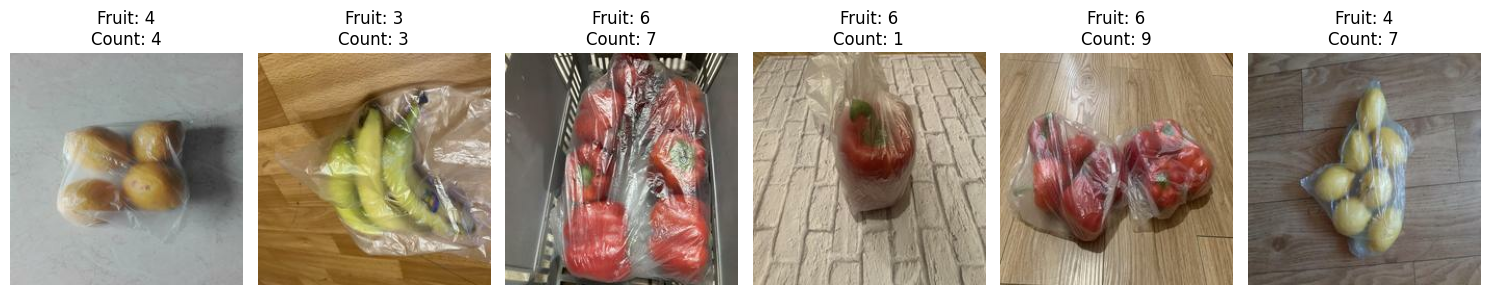

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Function to display a batch of random images with labels
def show_random_sample_images(dataset, num_images=6):
    # Take a random batch
    for batch in dataset.shuffle(1000).take(1):  # Shuffle dataset and take one batch
        images, labels_dict = batch  # Unpack the batch into images and labels

        # Access the labels from the dictionary
        fruit_labels = labels_dict["variety"].numpy()  # Access fruit variety label
        count_labels = labels_dict["count"].numpy()  # Access the count label (number of fruits)

        # Convert images tensor to numpy array
        images = images["image_input"].numpy()

        # Choose random indices for selecting images
        random_indices = np.random.choice(len(images), num_images, replace=False)

        # Create a figure to plot
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i, idx in enumerate(random_indices):
            axes[i].imshow(images[idx])  # Convert tensor to numpy array for visualization
            axes[i].axis("off")  # Remove axis ticks
            axes[i].set_title(f"Fruit: {int(fruit_labels[idx])}\n"
                              f"Count: {int(count_labels[idx])}")  # Display labels
        plt.tight_layout()  # Adjust layout so titles and images fit well
        plt.show()
        break  # Stop after one batch

# Show random sample images from train dataset
show_random_sample_images(train_dataset)


# Multi task learning

### Packed or not: binary classification -> sigmoid activation

### Fruit type: multiclass classification -> softmax activation

### Fruit count: regression -> linear activation

### Possible base models: MobileNetV2, ResNet50, EfficientNet

#### In base models the lower layers (feature extractor) detect basic image features, such as edges and shapes. The upper layers (classification head) are task-specific, such as fruit type, package presence, etc.

In [10]:
import tensorflow as tf


train_path = "/content/drive/MyDrive/packed_fruits/train_dataset.tfrecord"
val_path = "/content/drive/MyDrive/packed_fruits/val_dataset.tfrecord"

# Load datasets
train_dataset = tf.data.experimental.load(train_path)
val_dataset = tf.data.experimental.load(val_path)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


## MobileNetV2 allowing training

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

#Load basemodel without the Classification Head

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Unfreeze the base model, because we only train our custom classifier

base_model.trainable = True

# Only train the last 20 layers to prevent overfitting
for layer in base_model.layers[:-20]:
    layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## Adding classification heads

In [12]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model

# Image input (e.g., 224x224 RGB image)
image_input = Input(shape=(224, 224, 3), name="image_input")

# Additional features used during training (not used during inference)
num_fruits_input = Input(shape=(1,), name="num_fruits_input")  # Number of fruits in the image
packed_input = Input(shape=(1,), name="packed_input")  # Packed status (binary)
crowd_input = Input(shape=(1,), name="crowd_input")  # Packed status (binary)

# Process the additional structured inputs
y_num_fruits = Dense(32, activation='relu')(num_fruits_input)
y_num_fruits = Dropout(0.3)(y_num_fruits)

y_packed = Dense(32, activation='relu')(packed_input)
y_packed = Dropout(0.3)(y_packed)

y_crowd = Dense(32, activation='relu')(crowd_input)
y_crowd = Dropout(0.3)(y_crowd)

# Combine the additional structured data
structured_combined = Concatenate()([y_num_fruits, y_packed, y_crowd])

# Pre-trained base model (MobileNetV2)
x = base_model(image_input)  # Assuming base_model is pre-trained MobileNetV2
x = GlobalAveragePooling2D()(x)  # Global average pooling to flatten feature map

# Combine the features from both the image and the structured data
combined = Concatenate()([x, structured_combined])

# Output 1: Fruit variety (multi-class classification)
output_variety = Dense(10, activation="softmax", name="variety")(combined)  # Assuming 10 fruit types

# Output 2: Fruit count (regression)
output_count = Dense(1, activation="linear", name="count")(combined)  # Predict total number of fruits (regression)

# Create the multi-input, multi-output model
model = Model(inputs=[image_input, num_fruits_input, packed_input, crowd_input],
              outputs=[output_variety, output_count])

# Model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ num_fruits_input          │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ packed_input (InputLayer) │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crowd_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_input (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │             64 │ num_fruits_input[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │             64 │ packed_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │             64 │ crowd_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 7, 7, 1280)     │      2,257,984 │ image_input[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1280)           │              0 │ mobilenetv2_1.00_224[… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 96)             │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0],       │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1376)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ variety (Dense)           │ (None, 10)             │         13,770 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ count (Dense)             │ (None, 1)              │          1,377 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,273,323 (8.67 MB)

 Trainable params: 1,221,419 (4.66 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

## Compile the model

Instead of Mean Squared Error (mse), try Huber Loss to reduce the effect of outliers.

In [13]:
from tensorflow.keras.optimizers import Adam

# Recompile the model after unfreezing layers
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for fine-tuning
    loss={
        "variety": "sparse_categorical_crossentropy",
        "count": tf.keras.losses.Huber(), # More robust loss for counting
    },
    metrics={
        "variety": "accuracy",
        "count": "mae",
    }
)

print("✅ Model fine-tuned. Ready for further training!")


✅ Model fine-tuned. Ready for further training!


# Model Training

In [14]:
import tensorflow as tf

train_path = "/content/drive/MyDrive/packed_fruits/train_dataset.tfrecord"
val_path = "/content/drive/MyDrive/packed_fruits/val_dataset.tfrecord"

# Load datasets
train_dataset = tf.data.experimental.load(train_path)
val_dataset = tf.data.experimental.load(val_path)

# Re-create train and test datasets
train_dataset = create_dataset(df_train)
val_dataset = create_dataset(df_val)


# Print dataset batch sizes
for batch in train_dataset.take(1):
    print(f"✅ Train Batch Shape: {batch[0]['image_input'].shape}")

for batch in val_dataset.take(1):
    print(f"✅ Validation Batch Shape: {batch[0]['image_input'].shape}")

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
)

✅ Train Batch Shape: (32, 224, 224, 3)
✅ Validation Batch Shape: (32, 224, 224, 3)
Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - count_loss: 1.1195 - count_mae: 1.5210 - loss: 1.9849 - variety_accuracy: 0.7579 - variety_loss: 0.8654 - val_count_loss: 4.3542 - val_count_mae: 4.8535 - val_loss: 5.6007 - val_variety_accuracy: 0.6054 - val_variety_loss: 1.2465
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - count_loss: 0.3989 - count_mae: 0.7451 - loss: 1.3435 - variety_accuracy: 0.7280 - variety_loss: 0.9446 - val_count_loss: 2.2776 - val_count_mae: 2.7670 - val_loss: 3.2639 - val_variety_accuracy: 0.6896 - val_variety_loss: 0.9863
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - count_loss: 0.3104 - count_mae: 0.6365 - loss: 1.0211 - variety_accuracy: 0.7814 - variety_loss: 0.7107 - val_count_loss: 1.3425 - val_count_mae: 1.8118 - val_loss: 2.0750 - val_variety_accuracy: 0.7454 - val_variety_loss: 0.7324
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - cou

In [ ]:
predictions = model.predict([X_new_image, np.zeros((X_new_image.shape[0], 4))])
fruit_variety = predictions[0]  # Class prediction (probabilities for each class)
fruit_count = predictions[1]    # Count prediction (regression output)

In [15]:
# Save the model in the new Keras format
model.save('model_train.keras')

# Load the trained model
trained_model = tf.keras.models.load_model('model_train.keras')

# Display the model architecture
trained_model.summary()

import sys
sys.exit() #add break point

SystemExit: 

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Inference Model

In [ ]:
# from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
# from tensorflow.keras.models import Model
# import tensorflow as tf

# # Define the image input for inference
# image_input_inference = Input(shape=(224, 224, 3), name="image_input_inference")

# # Additional features used during training (not used during inference)
# num_fruits_input = Input(shape=(1,), name="num_fruits_input")  # Number of fruits in the image
# packed_input = Input(shape=(1,), name="packed_input")  # Packed status (binary)
# crowd_input = Input(shape=(1,), name="crowd_input")  # Packed status (binary)


# # Process the additional structured inputs
# y_num_fruits = Dense(32, activation='relu')(num_fruits_input)
# y_num_fruits = Dropout(0.3)(y_num_fruits)

# y_packed = Dense(32, activation='relu')(packed_input)
# y_packed = Dropout(0.3)(y_packed)

# y_crowd = Dense(32, activation='relu')(crowd_input)
# y_crowd = Dropout(0.3)(y_crowd)

# # Combine the additional structured data
# structured_combined = Concatenate()([y_num_fruits, y_packed, y_crowd])


# # Pre-trained base model (MobileNetV2)
# base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)
# base_model.trainable = False

# # Apply the base model (MobileNetV2) to the image input
# x_inference = base_model(image_input_inference)
# x_inference = GlobalAveragePooling2D()(x_inference)

# # Combine the features from both the image and the structured data
# combined = Concatenate()([x_inference, structured_combined])


# # Output 1: Fruit variety (multi-class classification)
# output_variety_inference = Dense(10, activation="softmax", name="variety")(combined)

# # Output 2: Fruit count (regression)
# output_count_inference = Dense(1, activation="linear", name="count")(combined)

# # Create the inference model (image input only)
# inference_model = Model(inputs=[image_input_inference, num_fruits_input, packed_input, crowd_input],
#                         outputs=[output_variety_inference, output_count_inference])

# # Load the weights from the trained model
# inference_model.load_weights('model_train.keras')


# # Create a new model for inference
# inference_model_final = Model(inputs=[image_input_inference], outputs=[output_variety_inference, output_count_inference])


# # Print the summary to confirm everything looks correct
# inference_model_final.summary()

## Testing


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


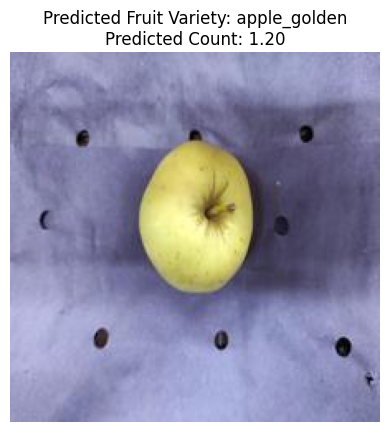

Image: /content/resized_dataset/test/test_batch_1_resized/test_apple_golden/002344.jpg
Predicted Fruit Variety: apple_golden
Predicted Fruit Count: 1.20
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


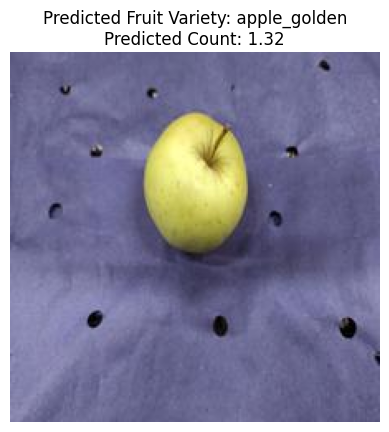

Image: /content/resized_dataset/test/test_batch_1_resized/test_apple_golden/001584.jpg
Predicted Fruit Variety: apple_golden
Predicted Fruit Count: 1.32
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


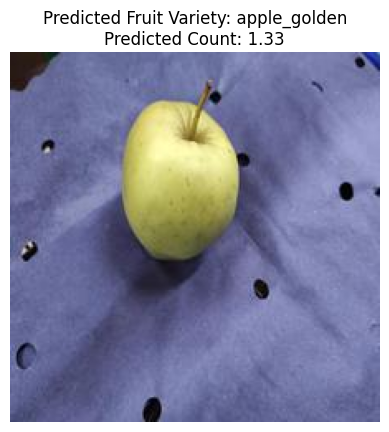

Image: /content/resized_dataset/test/test_batch_1_resized/test_apple_golden/003672.jpg
Predicted Fruit Variety: apple_golden
Predicted Fruit Count: 1.33
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


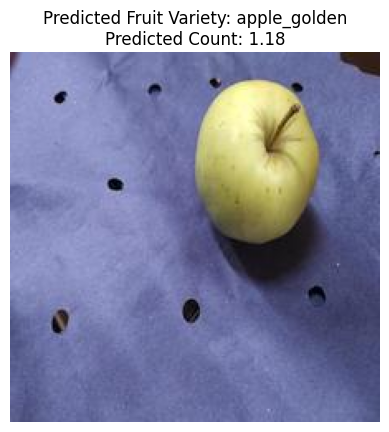

Image: /content/resized_dataset/test/test_batch_1_resized/test_apple_golden/076863.jpg
Predicted Fruit Variety: apple_golden
Predicted Fruit Count: 1.18
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


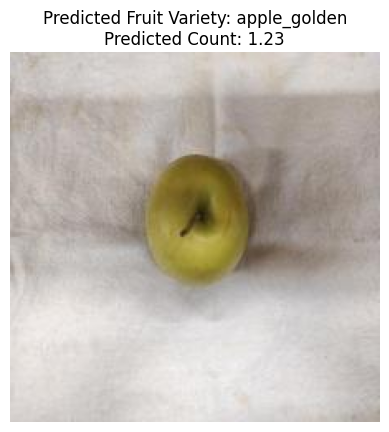

Image: /content/resized_dataset/test/test_batch_1_resized/test_apple_golden/039684.jpg
Predicted Fruit Variety: apple_golden
Predicted Fruit Count: 1.23
----------------------------------------


In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the class mapping for fruit varieties
class_mapping = {
    0: 'apple_golden',
    1: 'apple_granny',
    2: 'apple_spartan',
    3: 'banana_yellow',
    4: 'lemon_yellow',
    5: 'orange_orange',
    6: 'pepper_sweet_red',
    7: 'tangerine_tangerine',
    8: 'tomato_cherry_red',
    9: 'tomato_cherry_yellow'
}

# Load your test DataFrame (assuming df_test is already loaded)
df = df_test.copy()

# Loop through a subset (e.g., first 5 images) and predict
for index, row in df.head(5).iterrows():  # You can adjust how many samples you want to test
    # Load and preprocess the image
    img_path = row['file_path']
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to match model input
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]

    # Create placeholders for the structured data (assuming 4 features: 1 continuous, 2 binary)
    num_fruits_input = np.zeros((img_array.shape[0], 1))  # Placeholder for continuous feature (num_fruits)
    packed_input = np.full((img_array.shape[0], 1), -1)   # Placeholder for binary feature (packed)
    crowd_input = np.full((img_array.shape[0], 1), -1)    # Placeholder for binary feature (crowd)

    # Make predictions using the model (passing all 4 inputs)
    predictions = model.predict([img_array, num_fruits_input, packed_input, crowd_input])  # Pass all inputs

    # Extract the predictions
    fruit_variety = predictions[0]  # Class prediction (probabilities for each class)
    fruit_count = predictions[1]    # Count prediction (regression output)

    # Get predicted fruit variety (class with max probability)
    predicted_fruit_type_index = np.argmax(fruit_variety, axis=1)[0]  # Get class index with max probability
    predicted_fruit_type = class_mapping[predicted_fruit_type_index]

    # Get predicted fruit count (regression output)
    predicted_count = fruit_count[0][0]

    # Display the image and print the predictions
    plt.imshow(img)  # Display the image
    plt.axis('off')  # Turn off axis labels
    plt.title(f"Predicted Fruit Variety: {predicted_fruit_type}\nPredicted Count: {predicted_count:.2f}")
    plt.show()

    # Print the predictions (for debugging or checking)
    print(f"Image: {img_path}")
    print(f"Predicted Fruit Variety: {predicted_fruit_type}")
    print(f"Predicted Fruit Count: {predicted_count:.2f}")
    print("-" * 40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


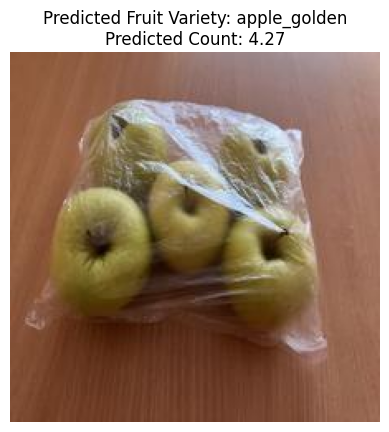

Image: /content/resized_dataset/test/test_batch_1_resized/test_apple_golden/023901.jpg
True Fruit Variety: apple_golden
Predicted Fruit Variety: apple_golden
Predicted Fruit Count: 4.27
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


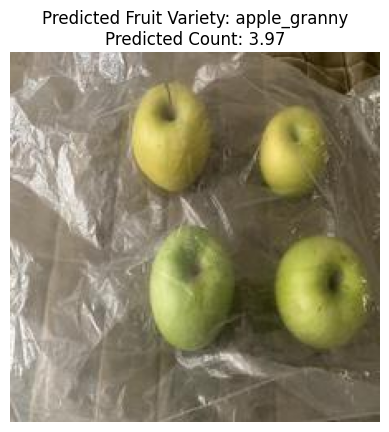

Image: /content/resized_dataset/test/test_batch_1_resized/test_apple_granny/102421.jpg
True Fruit Variety: apple_granny
Predicted Fruit Variety: apple_granny
Predicted Fruit Count: 3.97
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


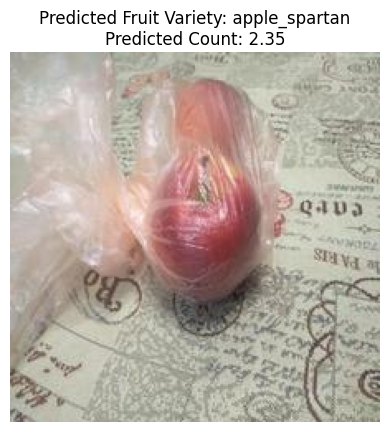

Image: /content/resized_dataset/test/test_batch_1_resized/test_apple_spartan/057054.jpg
True Fruit Variety: apple_spartan
Predicted Fruit Variety: apple_spartan
Predicted Fruit Count: 2.35
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


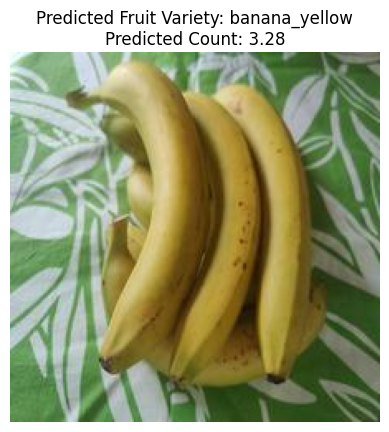

Image: /content/resized_dataset/test/test_batch_1_resized/test_banana_yellow/041662.jpg
True Fruit Variety: banana_yellow
Predicted Fruit Variety: banana_yellow
Predicted Fruit Count: 3.28
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


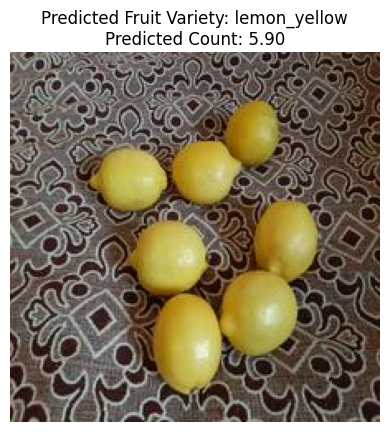

Image: /content/resized_dataset/test/test_batch_1_resized/test_lemon_yellow/067711.jpg
True Fruit Variety: lemon_yellow
Predicted Fruit Variety: lemon_yellow
Predicted Fruit Count: 5.90
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


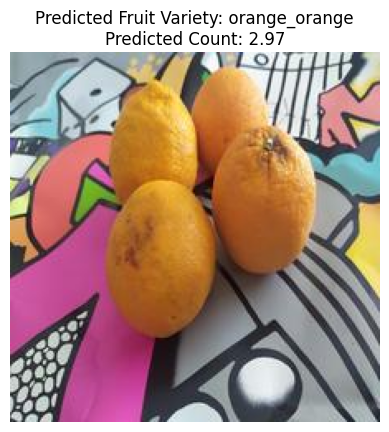

Image: /content/resized_dataset/test/test_batch_1_resized/test_orange_orange/056689.jpg
True Fruit Variety: orange_orange
Predicted Fruit Variety: orange_orange
Predicted Fruit Count: 2.97
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


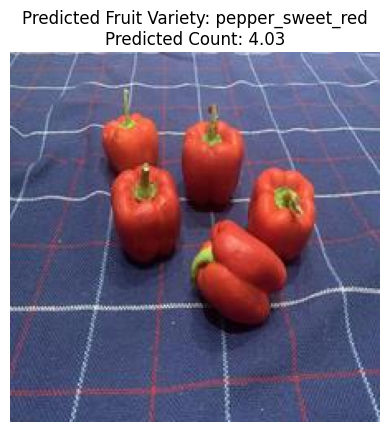

Image: /content/resized_dataset/test/test_batch_1_resized/test_pepper_sweet_red/076582.jpg
True Fruit Variety: pepper_sweet_red
Predicted Fruit Variety: pepper_sweet_red
Predicted Fruit Count: 4.03
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


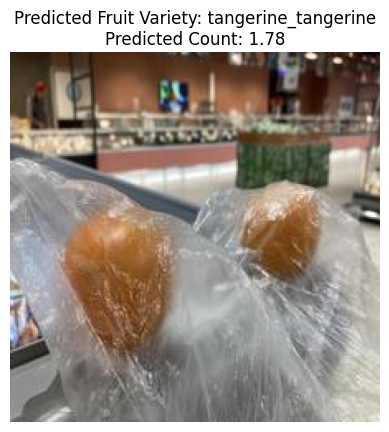

Image: /content/resized_dataset/test/test_batch_1_resized/test_tangerine_tangerine/063858.jpg
True Fruit Variety: tangerine_tangerine
Predicted Fruit Variety: tangerine_tangerine
Predicted Fruit Count: 1.78
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


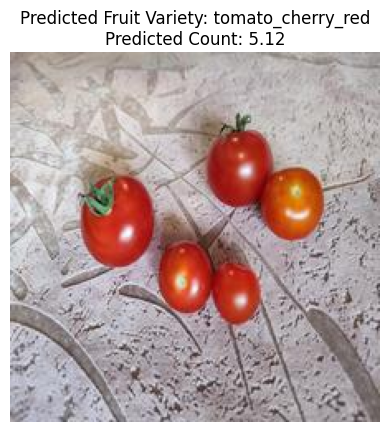

Image: /content/resized_dataset/test/test_batch_1_resized/test_tomato_cherry_red/034532.jpg
True Fruit Variety: tomato_cherry_red
Predicted Fruit Variety: tomato_cherry_red
Predicted Fruit Count: 5.12
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


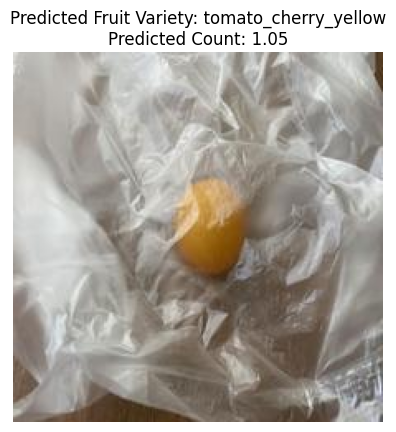

Image: /content/resized_dataset/test/test_batch_1_resized/test_tomato_cherry_yellow/059367.jpg
True Fruit Variety: tomato_cherry_yellow
Predicted Fruit Variety: tomato_cherry_yellow
Predicted Fruit Count: 1.05
----------------------------------------


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the class mapping for fruit varieties
class_mapping = {
    0: 'apple_golden',
    1: 'apple_granny',
    2: 'apple_spartan',
    3: 'banana_yellow',
    4: 'lemon_yellow',
    5: 'orange_orange',
    6: 'pepper_sweet_red',
    7: 'tangerine_tangerine',
    8: 'tomato_cherry_red',
    9: 'tomato_cherry_yellow'
}

# Load the test DataFrame (assuming df_test is already loaded)
df = df_test.copy()

# Get unique classes (fruit varieties) from the 'label' column
unique_classes = df['label'].unique()

# Loop through each unique class and select one image to test
for fruit_class in unique_classes:
    # Select one random sample of the current class
    class_df = df[df['label'] == fruit_class]
    sample_row = class_df.sample(n=1)  # Randomly pick one row from the class

    # Load and preprocess the image
    img_path = sample_row['file_path'].values[0]
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image to match model input
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]

    # Create placeholders for the structured data (assuming 4 features: 1 continuous, 2 binary)
    num_fruits_input = np.zeros((img_array.shape[0], 1))  # Placeholder for continuous feature (num_fruits)
    packed_input = np.full((img_array.shape[0], 1), -1)   # Placeholder for binary feature (packed)
    crowd_input = np.full((img_array.shape[0], 1), -1)    # Placeholder for binary feature (crowd)

    # Make predictions using the model (passing all 4 inputs)
    predictions = model.predict([img_array, num_fruits_input, packed_input, crowd_input])  # Pass all inputs

    # Extract the predictions
    fruit_variety = predictions[0]  # Class prediction (probabilities for each class)
    fruit_count = predictions[1]    # Count prediction (regression output)

    # Get predicted fruit variety (class with max probability)
    predicted_fruit_type_index = np.argmax(fruit_variety, axis=1)[0]  # Get class index with max probability
    predicted_fruit_type = class_mapping[predicted_fruit_type_index]

    # Get predicted fruit count (regression output)
    predicted_count = fruit_count[0][0]

    # Display the image and print the predictions
    plt.imshow(img)  # Display the image
    plt.axis('off')  # Turn off axis labels
    plt.title(f"Predicted Fruit Variety: {predicted_fruit_type}\nPredicted Count: {predicted_count:.2f}")
    plt.show()

    # Print the predictions (for debugging or checking)
    print(f"Image: {img_path}")
    print(f"True Fruit Variety: {class_mapping[fruit_class]}")
    print(f"Predicted Fruit Variety: {predicted_fruit_type}")
    print(f"Predicted Fruit Count: {predicted_count:.2f}")
    print("-" * 40)
